In [17]:
import oommfc as oc
import discretisedfield as df
import matplotlib.pyplot as plt
%matplotlib inline

# Tutorial 4 - Current induced domain wall motion

In this tutorial we show how spin transfer torque (STT) can be included in micromagnetic simulations. To illustrate that, we will try to move a domain wall pair using spin-polarised current.

Let us simulate a two-dimensional sample with length $L = 500 \,\text{nm}$, width $w = 20 \,\text{nm}$ and discretisation cell $(2.5 \,\text{nm}, 2.5 \,\text{nm}, 2.5 \,\text{nm})$. The material parameters are:

- exchange energy constant $A = 15 \,\text{pJ}\,\text{m}^{-1}$,
- Dzyaloshinskii-Moriya energy constant $D = 3 \,\text{mJ}\,\text{m}^{-2}$,
- uniaxial anisotropy constant $K = 0.5 \,\text{MJ}\,\text{m}^{-3}$ with easy axis $\mathbf{u}$ in the out of plane direction $(0, 0, 1)$,
- gyrotropic ratio $\gamma = 2.211 \times 10^{5} \,\text{m}\,\text{A}^{-1}\,\text{s}^{-1}$, and
- Gilbert damping $\alpha=0.3$.

In [27]:
# Definition of parameters
L = 500e-9  # sample length (m)
w = 20e-9  # sample width (m)
d = 2.5e-9  # discretisation cell size (m)
Ms = 5.8e5  # saturation magnetisation (A/m)
A = 15e-12  # exchange energy constant (J/)
D = 3e-3  # Dzyaloshinkii-Moriya energy constant (J/m**2)
K = 0.5e6  # uniaxial anisotropy constant (J/m**3)
u = (0, 0, 1)  # easy axis
gamma = 2.211e5  # gyromagnetic ratio (m/As)
alpha = 0.3  # Gilbert damping

# Mesh definition
p1 = (0, 0, 0)
p2 = (L, w, d)
cell = (d, d, d)
mesh = oc.Mesh(p1=p1, p2=p2, cell=cell)

# Micromagnetic system definition
system = oc.System(name="domain_wall_pair")
system.hamiltonian = oc.Exchange(A=A) + \
                     oc.DMI(D=D, kind="interfacial") + \
                     oc.UniaxialAnisotropy(K1=K, u=u)
system.dynamics = oc.Precession(gamma=gamma) + oc.Damping(alpha=alpha)

Because we want to move a DW pair, we need to initialise the magnetisation in an appropriate way before we relax the system.

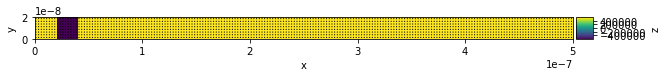

In [28]:
def m_value(pos):
    x, y, z = pos
    if 20e-9 < x < 40e-9:
        return (0, 0, -1)
    else:
        return (0, 0, 1)
    
system.m = df.Field(mesh, value=m_value, norm=Ms)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
system.m.plot_plane("z", ax=ax);

Now, we can relax the magnetisation.

2017/7/17 22:7: Calling OOMMF (domain_wall_pair/domain_wall_pair.mif) ... [9.6s]


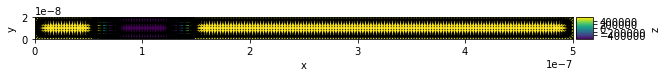

In [29]:
md = oc.MinDriver()
md.drive(system)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
system.m.plot_plane("z", ax=ax)

Now we can add the STT term to the dynamics equation.

In [30]:
ux = 400  # velocity in x direction (m/s)
beta = 0.5  # non-adiabatic STT parameter

system.dynamics += oc.STT(u=(ux, 0, 0), beta=beta)  # please notice the use of `+=` operator

And drive the system for half a nano second:

2017/7/17 22:8: Calling OOMMF (domain_wall_pair/domain_wall_pair.mif) ... [6.8s]


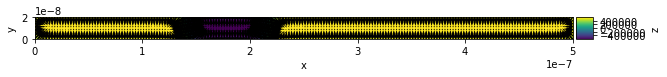

In [31]:
td = oc.TimeDriver()
td.drive(system, t=0.5e-9, n=100)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
system.m.plot_plane("z", ax=ax);

We see that the DW pair has moved to the positive $x$ direction.

### Exercise

Modify the code below (which is a copy of the example from above) to obtain one domain wall instead of a domain wall pair and move it using the same current.

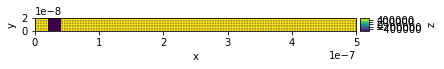

In [18]:
# Definition of parameters
L = 500e-9  # sample length (m)
w = 20e-9  # sample width (m)
d = 2.5e-9  # discretisation cell size (m)
Ms = 5.8e5  # saturation magnetisation (A/m)
A = 15e-12  # exchange energy constant (J/)
D = 3e-3  # Dzyaloshinkii-Moriya energy constant (J/m**2)
K = 0.5e6  # uniaxial anisotropy constant (J/m**3)
u = (0, 0, 1)  # easy axis
gamma = 2.211e5  # gyromagnetic ratio (m/As)
alpha = 0.3  # Gilbert damping

# Mesh definition
p1 = (0, 0, 0)
p2 = (L, w, d)
cell = (d, d, d)
mesh = oc.Mesh(p1=p1, p2=p2, cell=cell)

# Micromagnetic system definition
system = oc.System(name="domain_wall")
system.hamiltonian = oc.Exchange(A=A) + \
                     oc.DMI(D=D, kind="interfacial") + \
                     oc.UniaxialAnisotropy(K1=K, u=u)
system.dynamics = oc.Precession(gamma=gamma) + oc.Damping(alpha=alpha)

def m_value(pos):
    x, y, z = pos
    if 20e-9 < x < 40e-9:
        return (0, 0, -1)
    else:
        return (0, 0, 1)
    # We have added the y-component of 1e-8 to the magnetisation to be able to 
    # plot the vector field. This will not be necessary in the long run.
    
system.m = df.Field(mesh, value=m_value, norm=Ms)

system.m.plot_plane("z");

2017/7/12 18:22: Calling OOMMF (domain_wall/domain_wall.mif) ... [9.2s]


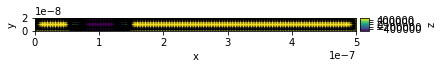

In [19]:
md = oc.MinDriver()
md.drive(system)

system.m.plot_plane("z");

2017/7/12 18:25: Calling OOMMF (domain_wall/domain_wall.mif) ... [6.8s]


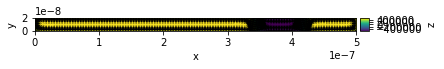

In [20]:
ux = 400  # velocity in x direction (m/s)
beta = 0.5  # non-adiabatic STT parameter

system.dynamics += oc.STT(u=(ux, 0, 0), beta=beta)

td = oc.TimeDriver()
td.drive(system, t=0.5e-9, n=100)

system.m.plot_plane("z")